## Import Module

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
np.random.seed(42)
%matplotlib inline

In [2]:
import wave
obj = wave.open('mike.wav','r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()

Number of channels 1
Sample width 2
Frame rate. 22050
Number of frames 191258
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=191258, comptype='NONE', compname='not compressed')


## Import data

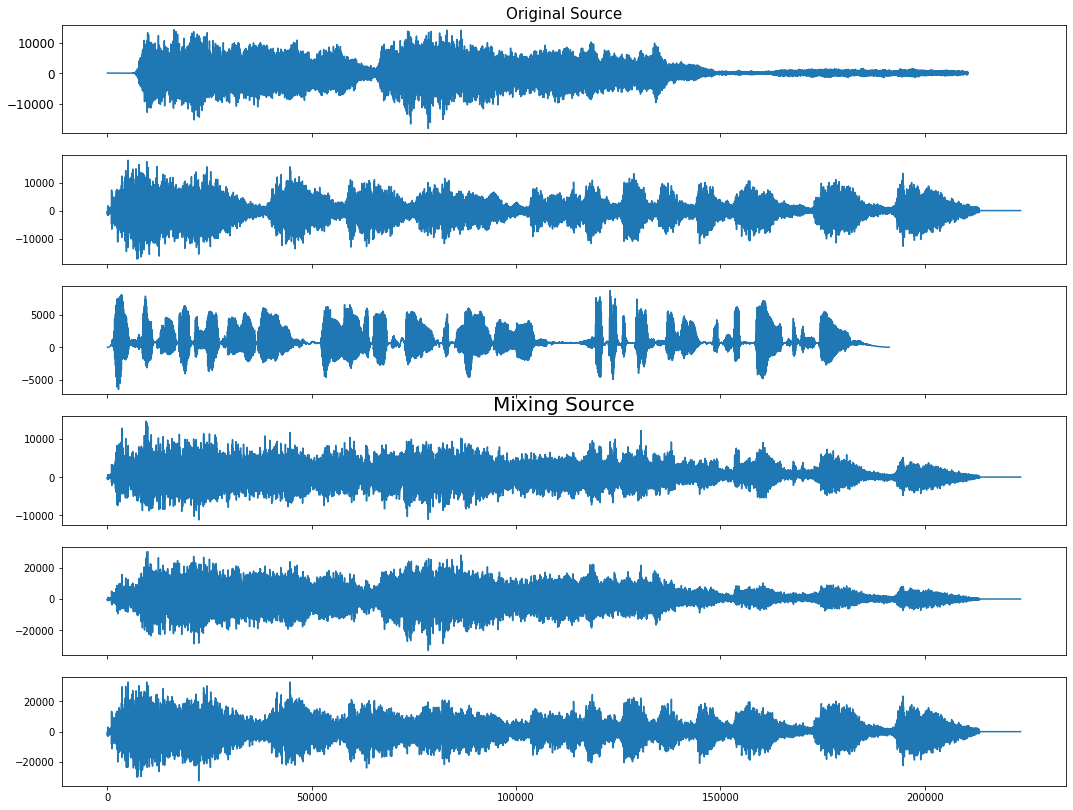

In [23]:
SR1, source1 = wavfile.read('beet.wav')
SR2, source2 = wavfile.read('beet92.wav')
SR3, source3 = wavfile.read('mike.wav')
MSR1, mix_source1 = wavfile.read('mixing1.wav')
MSR2, mix_source2 = wavfile.read('mixing2.wav')
MSR3, mix_source3 = wavfile.read('mixing3.wav')
Source=np.asarray([source1,source2,source3])
X=np.asarray([mix_source1,mix_source2,mix_source3])
fig, ax = plt.subplots(6, 1, figsize=[18, 14], sharex=True)
ax[0].plot(source1)
ax[1].plot(source2)
ax[2].plot(source3)
ax[3].plot(X[0])
ax[4].plot(X[1])
ax[5].plot(X[2])
ax[3].set_title('Mixing Source', fontsize=20)
ax[0].set_title('Original Source', fontsize=15)
ax[0].tick_params(labelsize=12)

plt.show()

In [4]:
n_sample=mix_source1.shape[0]
n_sample

223431

## Preprocessing Data
### 1.Centering Data
\begin{equation}\mathbf{D}=\mathbf{X}-\mu=\left(\begin{array}{c}
\mathbf{d}_{1} \\
\mathbf{d}_{2} \\
\vdots \\
\mathbf{d}_{n}
\end{array}\right)=\left(\begin{array}{c}
\mathbf{x}_{1}-\mu \\
\mathbf{x}_{2}-\mu \\
\vdots \\
\mathbf{x}_{n}-\mu
\end{array}\right)\end{equation}

In [5]:
# Centering Data
def center(X):
    center=np.mean(X,axis=1,keepdims=True)
    X_center=X-center
    return X_center

## Whitened Data
\begin{equation}\tilde{\mathbf{x}}=\mathbf{E D}^{-1 / 2} \mathbf{E}^{\mathrm{T}} \mathbf{x}\end{equation}
\begin{equation}\text{E is orthogonal matrix of eigenvector of covariance matrix}\end{equation}
\begin{equation}\text{D is diagonal matrix of eigenvalue of covariance matrix}\end{equation}

In [6]:
def whiten(X):
#Calculate covariance matrix of X
    covariance=np.cov(X)
#Calculate eigenvalue and eigenvector
    d, E = np.linalg.eigh(covariance)
    D = np.diag(d)
#Whiten data
    x_white=np.dot(E,np.dot(np.sqrt(np.linalg.inv(D)),np.dot(E.T,X)))
    return x_white

In [7]:
X_center=center(X)
X_white=whiten(X_center)

In [8]:
#Check data after preprocessing
print(np.round(np.cov(X_white)))
print(np.round(np.mean(X_white)))

[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]
-0.0


## Apply Fast ICA algorithm for preprocessing data
After preprocessing our data, we will apply Fast ICA algorithm to get independent component: 
\\

Steps to apply Fast ICA algorithm to data:
1. Give a random initial value for mixing matrix W
2. Calculate new mixing matrix W follow this formula:
\begin{equation}g(w^TX)=\tanh \left(W^T X\right)\space\space g'(W^TX)=1-\tanh^2 \left(W^T X\right)\end{equation}
\begin{equation}\mathbf{w}^{+}=E\left\{\mathbf{x} g\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}\right)\right\}-E\left(g^{\prime}\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}\right)\right\} \mathbf{w}\end{equation}
3. Normalize W follow this formula:
\begin{equation}\mathbf{w}=\mathbf{w}^{+} /\left\|\mathbf{w}^{+}\right\|\end{equation}
4. Check if W has converged or not, if not we will repeat steps 2,3. If W is converged stop the algorithm.

In [9]:
#Define g and g' function.
def g(X):
    g_x=np.tanh(X)
    return g_x
def g_d(X):
    g_d_x=1-(np.tanh(X))**2
    return g_d_x

In [10]:
#Calculate new mixing matrix W
def new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_d(np.dot(w.T, X)).mean() * w

    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

In [11]:
def Fastica(X, iterations,n_components=-1, tolerance=1e-5):
    if n_components < 1 :
        n_components = X.shape[0]
#Create random intial value for w
    W = np.zeros((n_components, n_components), dtype=X.dtype)

    for i in range(n_components):
        
        w = np.random.rand(n_components)
#Calculate and update new value for w        
        for j in range(iterations):
            
            w_new = new_w(w, X)
#Decorrelate output when use fastICA for many units.            
            if i > 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
#Check conrvege            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
#Calculate ICs       
    S = np.dot(W, X)
    
    return S

In [16]:
Estimate_S=Fastica(X_white,n_components=3,iterations=10000)

## Visualize the result

Text(0.5, 0, 'Independent Components')

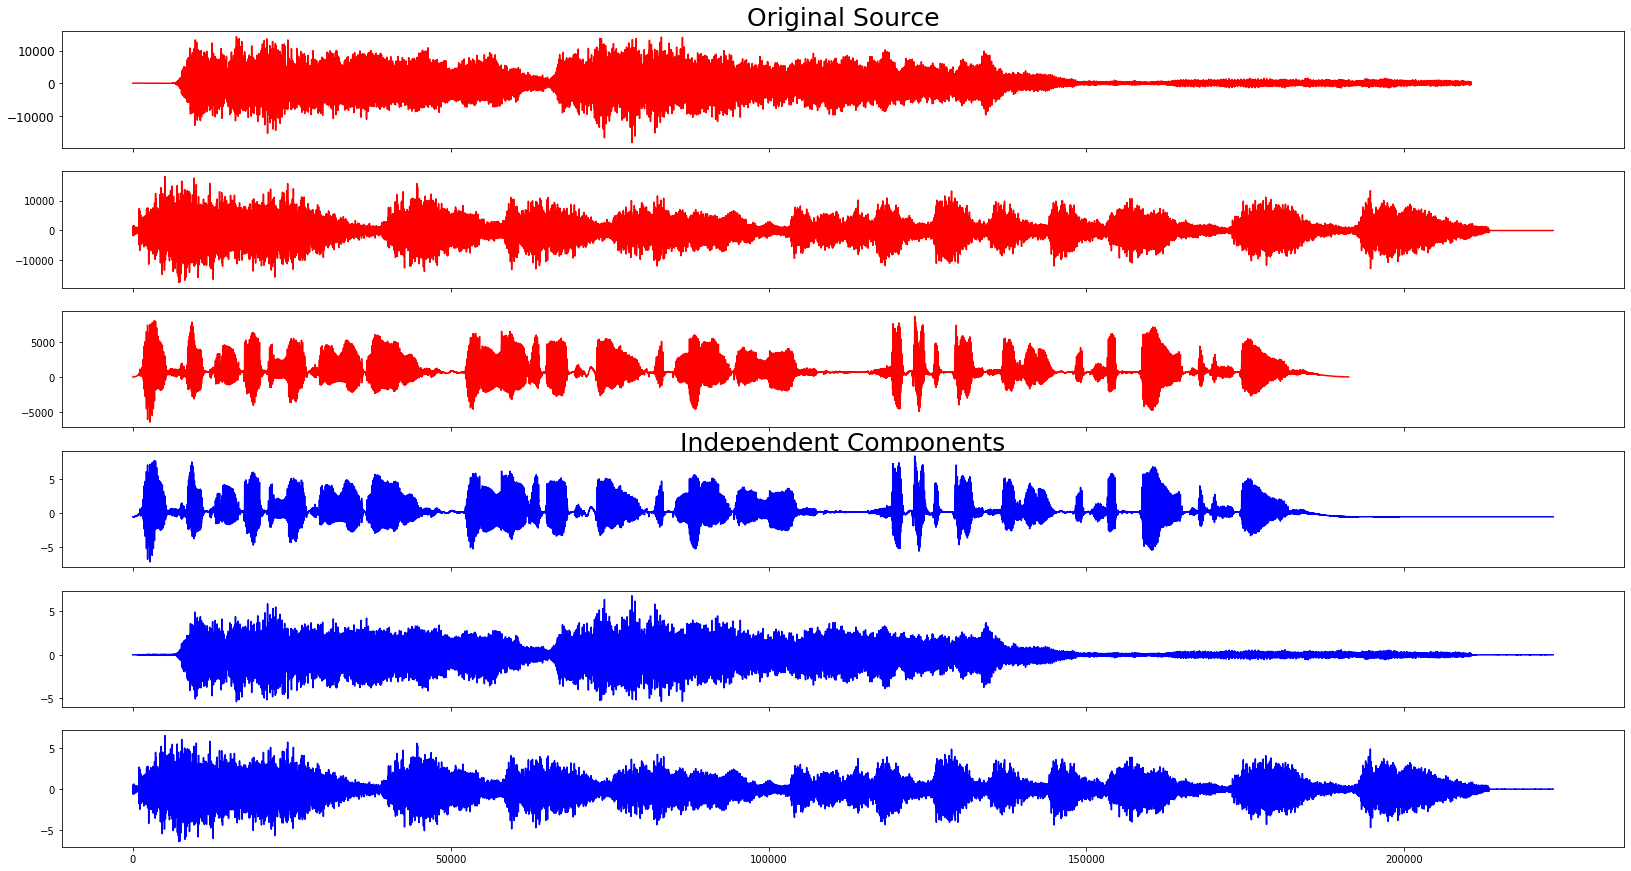

In [17]:
fig, ax = plt.subplots(6, 1, figsize=[28, 15], sharex=True)
ax[0].plot(source1,color='red')
ax[1].plot(source2,color='red')
ax[2].plot(source3,color='red')
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[3].plot(Estimate_S[0],color='blue')
ax[4].plot(Estimate_S[1],color='blue')
ax[5].plot(Estimate_S[2],color='blue')
ax[2].set_xlabel('Independent Components', fontsize=25)


## Export wav file

In [19]:
wavfile.write('out1.wav', SR1, Estimate_S[0])
wavfile.write('out2.wav', SR1, Estimate_S[1])
wavfile.write('out3.wav', SR1, Estimate_S[2])

## Compare with the results of fastICA algorithm in Sklearn module.

In [20]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3,algorithm='deflation',max_iter=1000)
S_ = ica.fit_transform(X.T)

In [21]:
S_=S_.T

Text(0.5, 0, 'Independent Components')

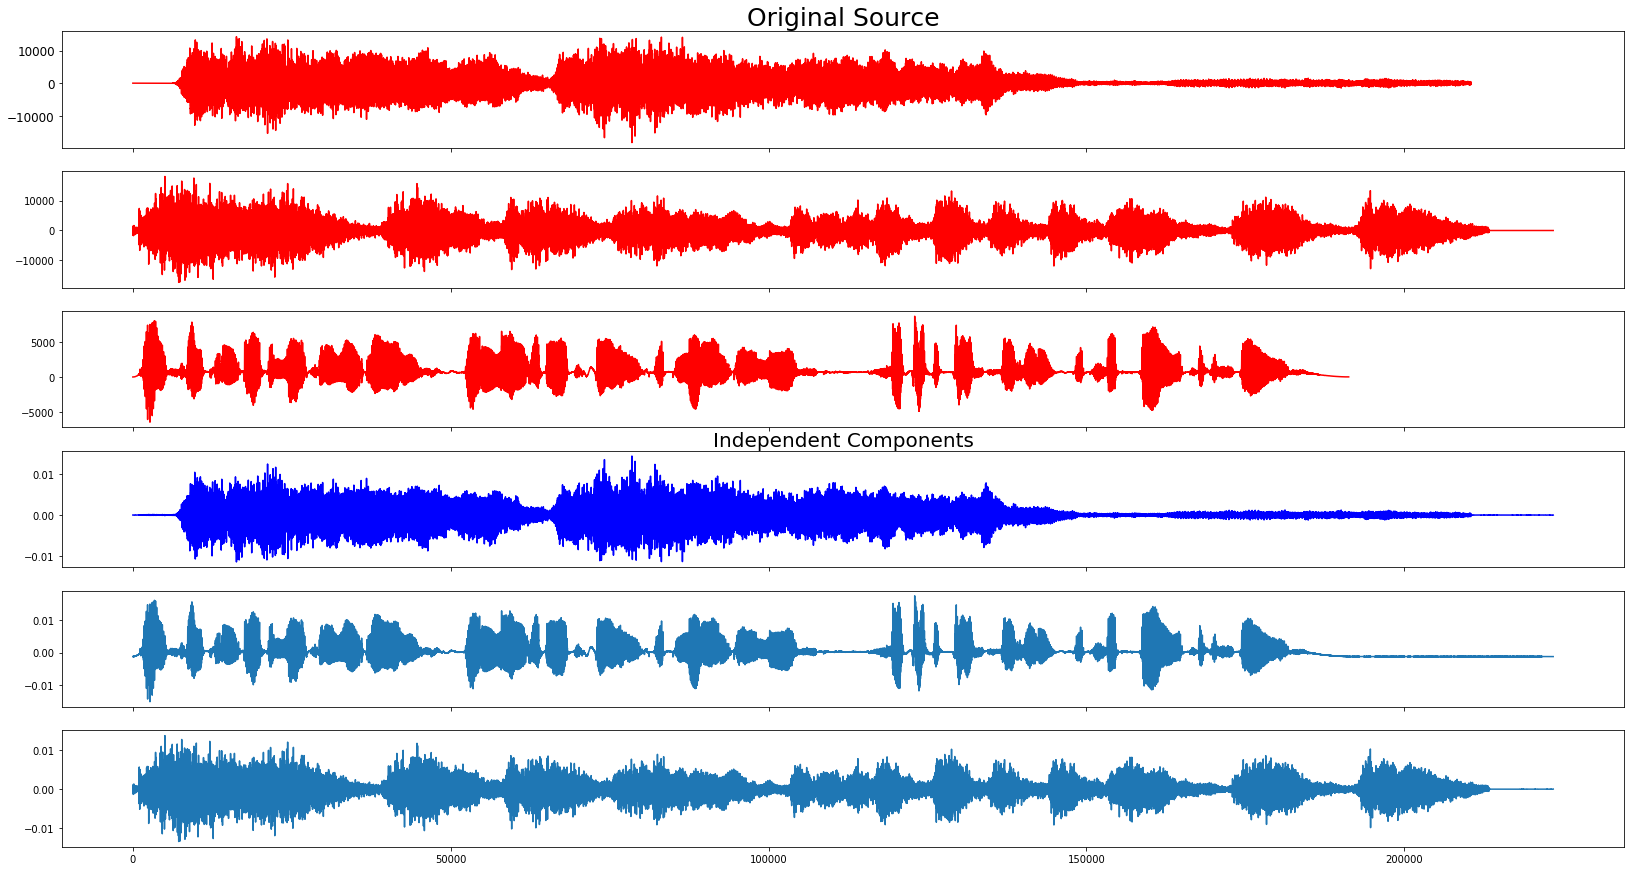

In [22]:
fig, ax = plt.subplots(6, 1, figsize=[28, 15], sharex=True)
ax[0].plot(source1,color='red')
ax[1].plot(source2,color='red')
ax[2].plot(source3,color='red')
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[3].plot(S_[0],color='blue')
ax[4].plot(S_[1])
ax[5].plot(S_[2])
ax[2].set_xlabel('Independent Components', fontsize=20)
